In [7]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
"""Sources and Background Research:

https://medium.com/@noel.B/a-complete-guide-to-using-simpy-for-ai-simulations-testing-fdc4ed1cf271#:~:text=SimPy%20is%20an%20excellent%20framework,projects%20requiring%20detailed%20environment%20modeling.
https://realpython.com/simpy-simulating-with-python/ (heavily used for framework)
https://simpy.readthedocs.io/
https://docs.python.org/3/tutorial/datastructures.html
https://campus.datacamp.com/courses/discrete-event-simulation-in-python/developing-discrete-event-models-using-simpy?ex=5
https://stackoverflow.com/questions/70937689/plotting-multiple-line-graphs-in-matplotlib
https://matplotlib.org/stable/index.html
https://stackoverflow.com/questions/30030659/in-python-what-is-the-difference-between-random-uniform-and-random-random#:~:text=105-,random.,end%20up%20giving%20you%20b%20).
https://www.geeksforgeeks.org/sympy-stats-uniform-in-python/
https://stackoverflow.com/questions/69609682/how-to-set-initial-queue-length-in-simpy

"""

Customer 0 arrives at 5.10 minutes
Customer 1 arrives at 5.23 minutes
Customer 2 arrives at 6.49 minutes
Customer 0 finished ordering at 6.65 minutes
Customer 1 finished ordering at 7.70 minutes
Customer 0 finished payment at 7.74 minutes
Customer 1 finished payment at 9.12 minutes
Customer 2 finished ordering at 9.27 minutes
Customer 0 received order at 9.83 minutes
Customer 2 finished payment at 10.49 minutes
Customer 3 arrives at 12.14 minutes
Customer 4 arrives at 12.27 minutes
Customer 1 received order at 13.34 minutes
Customer 3 finished ordering at 13.53 minutes
Customer 4 finished ordering at 14.36 minutes
Customer 3 finished payment at 15.12 minutes
Customer 2 received order at 16.00 minutes
Customer 4 finished payment at 16.17 minutes
Customer 5 arrives at 17.52 minutes
Customer 3 received order at 18.02 minutes
Customer 5 finished ordering at 19.91 minutes
Customer 4 received order at 21.04 minutes
Customer 5 finished payment at 21.07 minutes
Customer 6 arrives at 25.71 minu

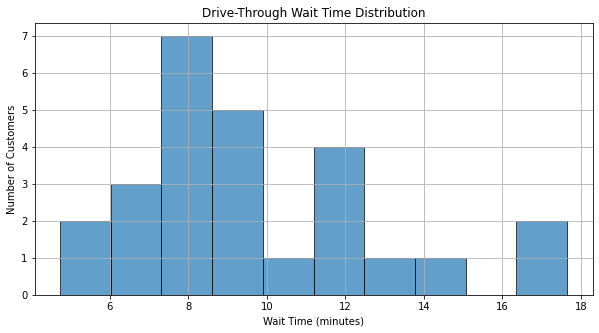

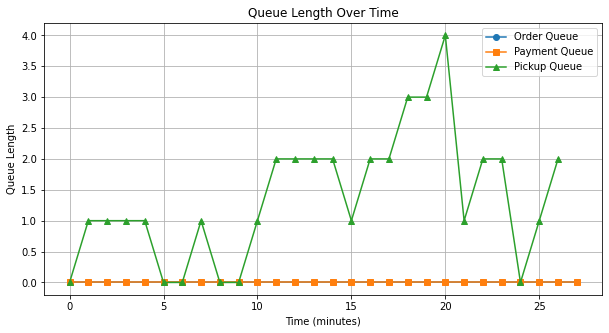

Max queue length at order station: 0
Max queue length at payment station: 0
Max queue length at pickup station: 4


In [45]:

# Constants
RANDOM_SEED = 42
NUM_ORDER_STATIONS = 4  # Number of order stations
NUM_PAYMENT_STATIONS = 2  # Number of payment stations
NUM_PICKUP_STATIONS = 1  # Number of pickup stations
ARRIVAL_RATE = 5  # Customers arrive every 5 minutes on average
SERVICE_TIME_ORDER = (1, 3)  # Order time range (min)
SERVICE_TIME_PAYMENT = (1, 2)  # Payment time range (min)
SERVICE_TIME_PICKUP = (2, 5)  # Pickup time range (min)
SIM_TIME = 120  # Simulation time in minutes

# Data collection
wait_times = []
queue_lengths = {"order": [], "payment": [], "pickup": []}
service_times = {"order": [], "payment": [], "pickup": []}
station_utilization = {"order": [], "payment": [], "pickup": []}

def customer(env, name, order_station, payment_station, pickup_station):
    """Simulate a customer's journey through the drive-through."""
    arrival_time = env.now
    print(f'{name} arrives at {arrival_time:.2f} minutes')

    # Ordering process
    with order_station.request() as req:
        queue_lengths["order"].append(len(order_station.queue))
        yield req
        order_time = random.uniform(*SERVICE_TIME_ORDER)
        service_times["order"].append(order_time)
        yield env.timeout(order_time)
        print(f'{name} finished ordering at {env.now:.2f} minutes')

    # Payment process
    with payment_station.request() as req:
        queue_lengths["payment"].append(len(payment_station.queue))
        yield req
        payment_time = random.uniform(*SERVICE_TIME_PAYMENT)
        service_times["payment"].append(payment_time)
        yield env.timeout(payment_time)
        print(f'{name} finished payment at {env.now:.2f} minutes')

    # Pickup process
    with pickup_station.request() as req:
        queue_lengths["pickup"].append(len(pickup_station.queue))
        yield req
        pickup_time = random.uniform(*SERVICE_TIME_PICKUP)
        service_times["pickup"].append(pickup_time)
        yield env.timeout(pickup_time)
        print(f'{name} received order at {env.now:.2f} minutes')

    # Store total time in system
    total_time = env.now - arrival_time
    wait_times.append(total_time)

def customer_generator(env, order_station, payment_station, pickup_station):
    """Generate customers at random intervals."""
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / ARRIVAL_RATE))
        env.process(customer(env, f'Customer {i}', order_station, payment_station, pickup_station))
        i += 1

def run_simulation():
    """Set up and run the simulation."""
    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    # Define drive-through resources
    order_station = simpy.Resource(env, NUM_ORDER_STATIONS)
    payment_station = simpy.Resource(env, NUM_PAYMENT_STATIONS)
    pickup_station = simpy.Resource(env, NUM_PICKUP_STATIONS)

    # Start customer generation
    env.process(customer_generator(env, order_station, payment_station, pickup_station))

    # Run simulation
    env.run(until=SIM_TIME)

    # Analytics
    print(f'Average total wait time: {np.mean(wait_times):.2f} minutes')
    print(f'Average order service time: {np.mean(service_times["order"]):.2f} minutes')
    print(f'Average payment service time: {np.mean(service_times["payment"]):.2f} minutes')
    print(f'Average pickup service time: {np.mean(service_times["pickup"]):.2f} minutes')

    # Plot histogram of total wait times
    plt.figure(figsize=(10, 5))
    plt.hist(wait_times, bins=10, edgecolor='black', alpha=0.7)
    plt.xlabel('Wait Time (minutes)')
    plt.ylabel('Number of Customers')
    plt.title('Drive-Through Wait Time Distribution')
    plt.grid()
    plt.show()

    # Plot queue length trends
    plt.figure(figsize=(10, 5))
    plt.plot(queue_lengths["order"], label="Order Queue", marker='o')
    plt.plot(queue_lengths["payment"], label="Payment Queue", marker='s')
    plt.plot(queue_lengths["pickup"], label="Pickup Queue", marker='^')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    # Print station utilization
    print(f'Max queue length at order station: {max(queue_lengths["order"])}')
    print(f'Max queue length at payment station: {max(queue_lengths["payment"])}')
    print(f'Max queue length at pickup station: {max(queue_lengths["pickup"])}')

if __name__ == '__main__':
    run_simulation()


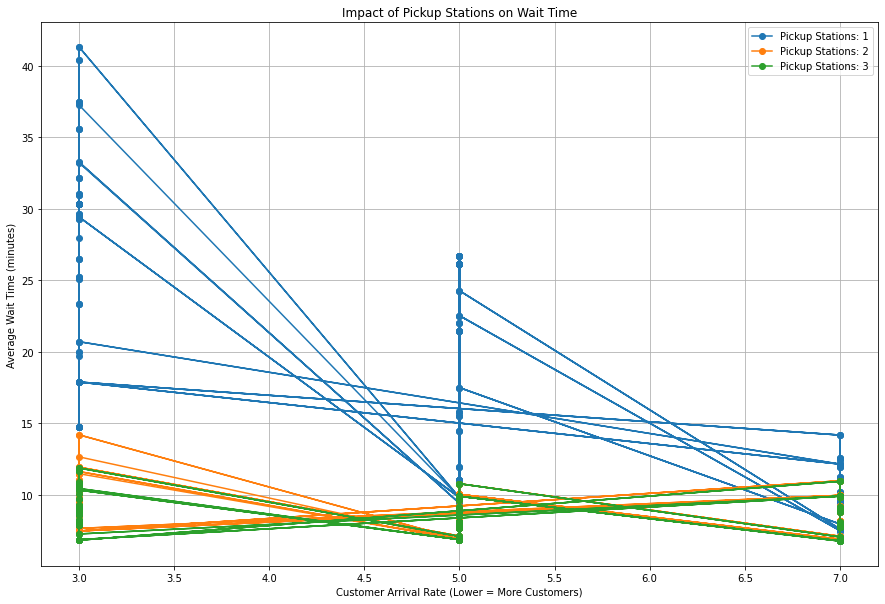


 Best (Lowest Wait Time) Configurations:
     Order Stations  Payment Stations  Pickup Stations  Arrival Rate  \
136               3                 2                3             7   
352               5                 2                3             7   
568               7                 2                3             7   
208               3                 3                3             7   
424               5                 3                3             7   

    Order Time Payment Time Pickup Time  Avg Wait Time  
136     (1, 3)       (1, 2)      (2, 5)       6.740944  
352     (1, 3)       (1, 2)      (2, 5)       6.740944  
568     (1, 3)       (1, 2)      (2, 5)       6.740944  
208     (1, 3)       (1, 2)      (2, 5)       6.758958  
424     (1, 3)       (1, 2)      (2, 5)       6.758958  

 Worst (Highest Wait Time) Configurations:
     Order Stations  Payment Stations  Pickup Stations  Arrival Rate  \
367               5                 3                1             

In [46]:
#The code below generally holds the same framework as above, but I have added multiple parameters for the
#constants to play around with how the graph looks
# Constants
RANDOM_SEED = 42
SIM_TIME = 120  # Simulation time in minutes

# Parameter ranges for simulation experiments
ORDER_STATIONS_RANGE = [3, 5, 7]  # Number of order stations
PAYMENT_STATIONS_RANGE = [1, 2, 3]  # Number of payment stations
PICKUP_STATIONS_RANGE = [1, 2, 3]  # Number of pickup stations
ARRIVAL_RATE_RANGE = [3, 5, 7]  # Customer arrival times (lower = more frequent)
SERVICE_TIME_ORDER_RANGE = [(1, 3), (2, 4)]  # Order service time variations
SERVICE_TIME_PAYMENT_RANGE = [(1, 2), (2, 3)]  # Payment service time variations
SERVICE_TIME_PICKUP_RANGE = [(2, 5), (3, 6)]  # Pickup service time variations

# Store results
experiment_results = []

def customer(env, name, order_station, payment_station, pickup_station, service_times, wait_times):
    """Simulate a customer's journey through the drive-through."""
    arrival_time = env.now

    # Ordering process
    with order_station.request() as req:
        yield req
        order_time = random.uniform(*service_times["order"])
        yield env.timeout(order_time)

    # Payment process
    with payment_station.request() as req:
        yield req
        payment_time = random.uniform(*service_times["payment"])
        yield env.timeout(payment_time)

    # Pickup process
    with pickup_station.request() as req:
        yield req
        pickup_time = random.uniform(*service_times["pickup"])
        yield env.timeout(pickup_time)

    # Store total wait time
    total_time = env.now - arrival_time
    wait_times.append(total_time)  


def customer_generator(env, order_station, payment_station, pickup_station, arrival_rate, service_times, wait_times):
    
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / arrival_rate))
        env.process(customer(env, f'Customer {i}', order_station, payment_station, pickup_station, service_times, wait_times))
        i += 1
        
    #trying to generate customers at random times in this function


        
#takes in 5 input parameters, initializes all the simpy resources      
def run_simulation(num_order_stations, num_payment_stations, num_pickup_stations, arrival_rate, service_times):
    """Run a single simulation with specified parameters."""
    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    # Define resources
    order_station = simpy.Resource(env, num_order_stations)
    payment_station = simpy.Resource(env, num_payment_stations)
    pickup_station = simpy.Resource(env, num_pickup_stations)

    wait_times = []  # Store actual wait times directly
    env.process(customer_generator(env, order_station, payment_station, pickup_station, arrival_rate, service_times, wait_times))

    # Run simulation
    env.run(until=SIM_TIME)

    # Return correct average wait time
    return np.mean(wait_times) if wait_times else 0


# Run experiments
for num_order in ORDER_STATIONS_RANGE:
    for num_payment in PAYMENT_STATIONS_RANGE:
        for num_pickup in PICKUP_STATIONS_RANGE:
            for arrival_rate in ARRIVAL_RATE_RANGE:
                for order_time in SERVICE_TIME_ORDER_RANGE:
                    for payment_time in SERVICE_TIME_PAYMENT_RANGE:
                        for pickup_time in SERVICE_TIME_PICKUP_RANGE:
                            # Run simulation with selected parameters
                            service_times = {"order": order_time, "payment": payment_time, "pickup": pickup_time}
                            avg_wait_time = run_simulation(num_order, num_payment, num_pickup, arrival_rate, service_times)

                            # Store results
                            experiment_results.append({
                                "Order Stations": num_order,
                                "Payment Stations": num_payment,
                                "Pickup Stations": num_pickup,
                                "Arrival Rate": arrival_rate,
                                "Order Time": order_time,
                                "Payment Time": payment_time,
                                "Pickup Time": pickup_time,
                                "Avg Wait Time": avg_wait_time
                            })

#NOTE - ChatGPT was utilized to help construct these nested for loops and tie results together in a neat and organized way
                            
df_results = pd.DataFrame(experiment_results)

#Impact of Pickup Stations on Wait Time
plt.figure(figsize=(15, 10))
for pickup_stations in PICKUP_STATIONS_RANGE:
    subset = df_results[df_results["Pickup Stations"] == pickup_stations]
    plt.plot(subset["Arrival Rate"], subset["Avg Wait Time"], label=f'Pickup Stations: {pickup_stations}', marker='o')

plt.xlabel('Customer Arrival Rate (Lower = More Customers)')
plt.ylabel('Average Wait Time (minutes)')
plt.title('Impact of Pickup Stations on Wait Time')
plt.legend()
plt.grid()
plt.show()

# Print top configurations
print("\n Best (Lowest Wait Time) Configurations:")
print(df_results.nsmallest(5, "Avg Wait Time"))

print("\n Worst (Highest Wait Time) Configurations:")
print(df_results.nlargest(5, "Avg Wait Time"))
